In [1]:
import numpy as np
import pandas as pd
import keras
import cv2
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

In [2]:
df = pd.read_csv('train.csv')
base_path="./images/"

In [3]:
df = df.drop('url', axis='columns')

In [4]:
df

,id,landmark_id
0,6e158a47eb2ca3f6,142820
1,202cd79556f30760,104169
2,3ad87684c99c06e1,37914
3,e7f70e9c61e66af3,102140
4,4072182eddd0100e,2474
...,...,...
4132909,fc0f007893b11ba7,172138
4132910,39aad18585867916,162860
4132911,fd0725460e4ebbec,191243
4132912,73691ae29e24ba19,145760


In [5]:
df = df.loc[df["id"].str.startswith(("000","001","002","003","004","005","006","007"), na=False),:]
num_classes = len(df["landmark_id"].unique())
num_data = len(df)

In [6]:
num_classes

7308

In [7]:
num_data

8082

In [8]:
data = pd.DataFrame(df["landmark_id"].value_counts())
data

,count
landmark_id,
138982,23
62798,10
171772,8
45428,7
83144,7
...,...
165070,1
135822,1
2417,1


In [9]:
data.reset_index(inplace=True)
data.columns=["landmark_id","count"]
data

,landmark_id,count
0,138982,23
1,62798,10
2,171772,8
3,45428,7
4,83144,7
...,...,...
7303,165070,1
7304,135822,1
7305,2417,1
7306,62702,1


In [10]:
data['count'].describe()

count    7308.000000
mean        1.105911
std         0.480640
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        23.000000
Name: count, dtype: float64

(array([0.000e+00, 0.000e+00, 6.718e+03, 0.000e+00, 4.800e+02, 0.000e+00,
        7.700e+01, 0.000e+00, 2.300e+01, 0.000e+00, 4.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

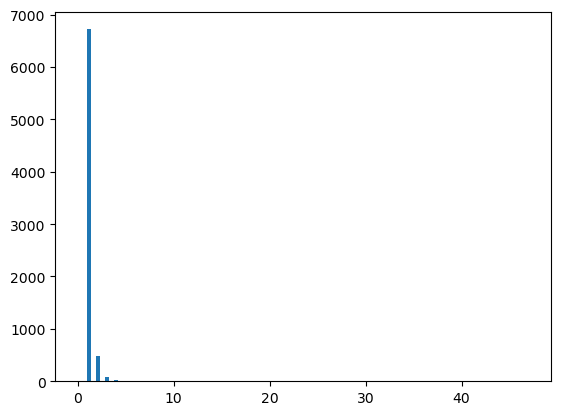

In [11]:
plt.hist(data['count'], 100, range = (0,47), label = 'test')

In [12]:
data['count'].between(0,5).sum()

7302

In [13]:
data['count'].between(5,10).sum()

9

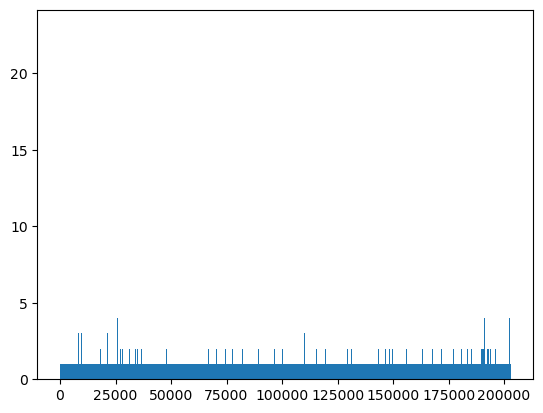

In [14]:
unique_landmark_id = sorted(df["landmark_id"].unique())

plt.hist(df["landmark_id"], bins=unique_landmark_id)
plt.show()

In [15]:
from sklearn.preprocessing import LabelEncoder
lencoder = LabelEncoder()
lencoder.fit(df["landmark_id"])

LabelEncoder()

In [16]:
def encode_label(label):
    return lencoder.transform(label)

In [17]:
def decode_label(label):
    return lencoder.inverse_transform(label)

In [18]:
def get_image_from_numbers(num): 
    fname, label = df.loc[num, :]
    fname = fname + '.jpg'
    f1 = fname[0]
    f2 = fname [1]
    f3 = fname [2]
    path = os.path.join(base_path, f1, f2, f3, fname)
    im = cv2.imread(os.path.join(base_path, path))
    return im, label

4 Sample images from random classes


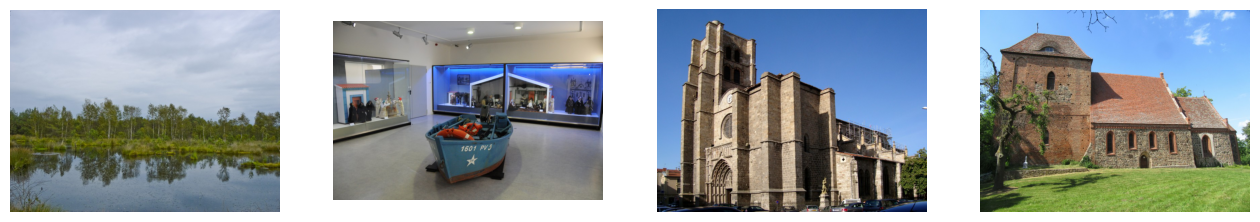

In [19]:
print("4 Sample images from random classes")
fig = plt.figure(figsize=(16,16))
for i in range(1,5):
    ri = random.choices(os.listdir(base_path), k=3)
    folder = base_path + '/' + ri[0] + '/' + ri[1] + '/' + ri[2]     
    random_img = random.choice(os.listdir(folder))
    img = np.array(Image.open(os.path.join(folder, random_img)))
    fig.add_subplot(1,4,i) 
    plt.imshow(img)
    plt.axis('off')
plt.show()


In [20]:
from keras.applications import VGG19
from keras.layers import *
from keras import Sequential
# Parameters
learning_rate   = 0.0001
decay_speed     = 1e-6
momentum        = 0.09
loss_function   = "sparse_categorical_crossentropy"
source_model = VGG19(weights=None)
#new_layer = Dense(num_classes, activation=activations.softmax, name='prediction')
drop_layer = Dropout(0.5)
drop_layer2 = Dropout(0.5)
model = Sequential()
for layer in source_model.layers[:-1]: # go through until last layer
    if layer == source_model.layers[-25]:
        model.add(BatchNormalization())
    model.add(layer)
#     if layer == source_model.layers[-3]:
#         model.add(drop_layer)
# model.add(drop_layer2)
model.add(Dense(num_classes, activation="softmax"))
model.summary()
optim1 = keras.optimizers.RMSprop(learning_rate = 0.0001, momentum = 0.09)
optim2 = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=optim1,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
#sgd = SGD(lr=learning_rate, decay=decay_speed, momentum=momentum, nesterov=True)
rms = keras.optimizers.RMSprop(learning_rate=learning_rate , momentum=momentum)
model.compile(optimizer=rms,
              loss=loss_function,
              metrics=["accuracy"])
print("Model compiled!")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 224, 224, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 169,511,128 (646.63 MB)

 Trainable params: 169,511,122 (646.63 MB)

 Non-trainable params: 6 (24.00 B)

Model compiled!


In [21]:
def get_image_from_number(num, df):
    fname, label = df.iloc[num,:]
    fname = fname + ".jpg"
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1,f2,f3,fname)
    im = cv2.imread(os.path.join(base_path,path))
    #print((os.path.join(base_path,path)))
    assert img is not None, "file could not be read, check with os.path.exists()"
    #plt.imshow(np.array(im))
    return im, label

def image_reshape(im, target_size):
    return cv2.resize(im, target_size)

def get_batch(dataframe,start, batch_size):
    image_array = []
    label_array = []
    end_img = start+batch_size

    if end_img > len(dataframe):
        end_img = len(dataframe)
        
    for idx in range(start, end_img):
        n = idx
        im, label = get_image_from_number(n, dataframe)
        im = image_reshape(im, (224, 224)) / 255.0
        image_array.append(im)
        label_array.append(label)

    label_array = encode_label(label_array)
    
    return np.array(image_array), np.array(label_array)

In [22]:
batch_size = 16
epoch_shuffle = True
weight_classes = True
epochs = 1

# Split train data up into 80% and 20% validation
train, validate = np.split(df.sample(frac=1), [int(.8*len(df))])
print("Training on:", len(train), "samples")
print("Validation on:", len(validate), "samples")

for e in range(epochs):
    print("Epoch: ", str(e+1) + "/" + str(epochs))
    if epoch_shuffle:
        train = train.sample(frac = 1)
    for it in range(int(np.ceil(len(train)/batch_size))):
        X_train, y_train = get_batch(train, it*batch_size, batch_size)
        model.train_on_batch(X_train, y_train)

Training on: 6465 samples
Validation on: 1617 samples
Epoch:  1/1


In [1]:
batch_size = 16
errors = 0
good_preds = [] 
bad_preds = []

for it in range(int(np.ceil(len(val)/batch_size))): 
    x_val, y_val = get_batch(val, it*batch_size, batch_size)
    result = model.predict(x_val)
    cla = np.argmax(result, axis=1)
    for idx, res in enumerate(result):
        if cla[idx] != y_val[idx]:
            errors = errors+1
            bad_preds.append([batch_size*it + idx], cla[idx], res[cla[idx]]) 
        else:
            good_preds.append([batch_size*it + idx], cla[idx], res[cla[idx]])
                               
for i in range(1,6):
    n = int(good_preds[0])
    img.lbl = get_image_from_numbers(n, val)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

NameError: name 'np' is not defined